# Visualization

In [1]:
import numpy as np
import time
import datetime 
import json
from tqdm import tqdm
import os
import tensorflow as tf
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()

from data_utils_LMR import prepare_data,read_data, EncoderDecoder
from model import Vrae as Vrae_model
from batch import Generator

training_dir = 'logs/'
#training_dir += 'state1024_layers2_latent16_batch256_LSTM_seqs15-30_8e-3'
#training_dir += 'state1024_layers2_latent16_batch256_LSTM_seqs15-30_8e-3_d0.5'
training_dir += 'state1024_layers2_latent16_batch512_LSTM_seqs15-30_8e-3_B0.01_f32'

# sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyzer = SentimentIntensityAnalyzer()
def getSentimentScore(sentence):
    scores = sentimentAnalyzer.polarity_scores(sentence)
    return (scores['neg'], scores['neu'] ,scores['pos'])

print getSentimentScore("I'm lucky!")

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
with open(training_dir +'/flags.json', 'r') as fp:
    FLAGS = dotdict(json.loads( fp.read() ) )
    
for k,v in FLAGS.iteritems():
    print k,':',v
      
n_samples = 3000

FLAGS.sequence_max = 45

Loading BokehJS ...

(0.0, 0.244, 0.756)
sequence_max : 30
beta_period : 10
training_dir : logs/state1024_layers2_latent16_batch512_LSTM_seqs15-30_8e-3_B0.01_f32
batch_size : 512
num_layers : 2
initialize : False
learning_rate_change_rate : 1500
sequence_min : 15
latent_dim : 16
dtype_precision : 32
state_size : 1024
cell : LSTM
initial_learning_rate : 0.0008
epoches : 10000
output_keep_prob : 0.5
acceptable_accuracy : 0.8
input_keep_prob : 0.8
latent_loss_weight : 0.01


/home/ubuntu/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Prepare data

Data already downloaded.
Creating Vocabulary..
Vocabulary already created.
Converting sentences to sequences of ids..
  reading data line 10000
  reading data line 20000
  reading data line 30000
37393  sentences


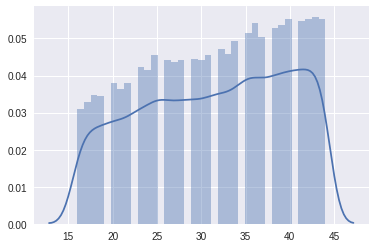

In [2]:
# vocabulary encoder-decoder
encoderDecoder = EncoderDecoder()
num_symbols = encoderDecoder.vocabularySize()
# prepare data
prepare_data(1000)
sentences, ratings = read_data( max_size=None, max_sentence_size=int(FLAGS.sequence_max),min_sentence_size=int(FLAGS.sequence_min)) 
print len(sentences), " sentences"
sns.distplot( [len(sent) for sent in sentences])
plt.show()

## Loading models

In [ ]:
batch_gen = Generator(sentences, ratings, n_samples )
num_iters = FLAGS.epoches * batch_gen.iterations_per_epoch()
# text decoder ( text <-> ids)
encoderDecoder = EncoderDecoder()

config = tf.ConfigProto(
        device_count = {'GPU': 0}, # do not use GPU for testing
    )
# load model
vrae_model = Vrae_model(state_size=int(FLAGS.state_size),
                         num_layers=int(FLAGS.num_layers),
                          latent_dim=int(FLAGS.latent_dim),
                         batch_size=n_samples,
                         num_symbols=num_symbols,
                        latent_loss_weight=float(FLAGS.latent_loss_weight),
                         dtype_precision=FLAGS.dtype_precision,
                        cell_type=FLAGS.cell, 
                        input_keep_prob=float(FLAGS.input_keep_prob),
                        output_keep_prob=float(FLAGS.output_keep_prob)
                       )

## Generating test data

In [13]:
saver = tf.train.Saver()
#print train_dir
samples = []
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    padded_batch_xs, batch_ratings, batch_lengths, batch_weights, max_length = batch_gen.next_batch()
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val, losses  = vrae_model.reconstruct( sess, padded_batch_xs,batch_lengths, batch_weights)
print "Done!"    

INFO:tensorflow:Restoring parameters from ./logs/state1024_layers2_latent16_batch512_LSTM_seqs15-30_8e-3_B0.01_f32/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/state1024_layers2_latent16_batch512_LSTM_seqs15-30_8e-3_B0.01_f32/model.ckp



Done!


In [14]:
vaderSentiments = [ getSentimentScore(encoderDecoder.prettyDecode(padded_batch_xs[i])) for i in xrange(n_samples)]

## Reconstruction

In [31]:
for _ in range(10):
    i = int(np.random.random()*n_samples)
    print vaderSentiments[i],"rating:", batch_ratings[i]
    print encoderDecoder.prettyDecode( padded_batch_xs[i] )
    print encoderDecoder.prettyDecode( np.argmax(x_reconstruct[i], axis= 1) )
    print "------------------------------------------"

(0.0, 1.0, 0.0) rating: 8
a cult film waiting to happen!
a cult film saitting 000rvvr aa             
------------------------------------------
(0.488, 0.512, 0.0) rating: 10
don't be surprised if you cry too
don't be serprined yyu wou rennmey          
------------------------------------------
(0.0, 1.0, 0.0) rating: 10
this movie is a collectors item.
this movie is a coddelhin aat a             
------------------------------------------
(0.502, 0.498, 0.0) rating: 2
but this film was a fullout travesty.
but this film was a luscrauch ng gorre      
------------------------------------------
(0.518, 0.482, 0.0) rating: 1
yup, he's a serial killer cop.
yep, he's a  oreaatalk  to ormr             
------------------------------------------
(0.0, 0.654, 0.346) rating: 4
gruner loves to kick and kick and kick.
sriner likks do lind and  anee   e   in     
------------------------------------------
(0.474, 0.526, 0.0) rating: 4
i must have been blind.
i just have bee eeee rli             

## Reconstruction in the Latent Space

In [16]:
# dimension reduction
from sklearn.manifold import TSNE
X = np.array(z_vals)
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
zs_reduced = model.fit_transform(X) 
xs = [ zs_reduced[i,0] for i in xrange(n_samples) ]
ys = [ zs_reduced[i,1] for i in xrange(n_samples) ]

In [17]:
output_file("latent_space.html")

source = ColumnDataSource(
        data=dict(
            x=xs,
            y=ys,
            input= [encoderDecoder.prettyDecode(x) for x in padded_batch_xs],
            output= [encoderDecoder.prettyDecode(np.argmax(y, axis= 1) ) for y in x_reconstruct],
            rating=batch_ratings,
            sent= vaderSentiments
        )
    )

colors = [ "#%02x%02x%02x" % ( 100 + 150 * r[0] ,  100 + 150 * r[2]  , 100 + 100 * r[1]  ) for r in vaderSentiments ]

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("input", "@input"),
            ("output", "@output"),
            ("rating", "@rating"),
        ]
    )

p = figure(plot_width=1000, plot_height=600, tools=[hover],title="Latent space")

p.circle('x', 'y', size=8, source=source, fill_color=colors)

show(p)

INFO:bokeh.core.state:Session output file 'latent_space.html' already exists, will be overwritten.
/home/ubuntu/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


## Sentiment Distribution

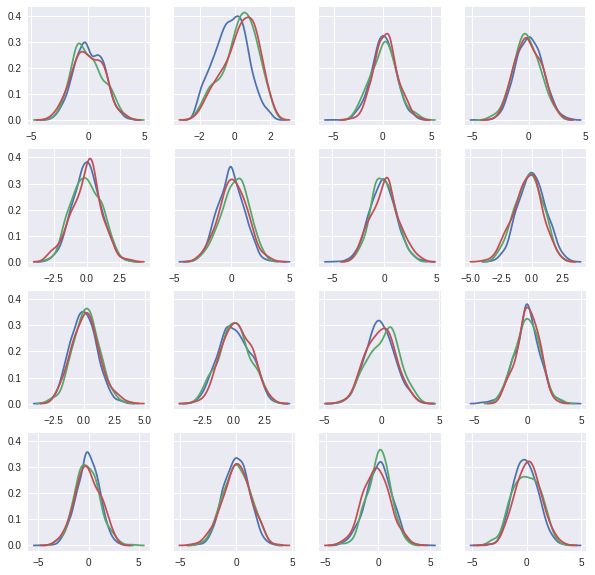

In [18]:
import seaborn as sns
cols = sns.color_palette()
pos = []
neg = []
neu = []
major_sent = np.argmax(vaderSentiments, axis = 1)
for i in xrange(n_samples):
    if major_sent[i] == 2:
        pos.append( z_mean_val[i,:] )
    elif major_sent[i] == 0:
        neg.append( z_mean_val[i,:] )
    else:
        neu.append( z_mean_val[i,:] )
        
pos = np.array(pos)
neg = np.array(neg)
neu = np.array(neu)

side_lenght = int(np.sqrt(int(FLAGS.latent_dim)))
f, axs = plt.subplots(ncols=side_lenght, nrows=side_lenght, sharey=True, figsize=(10, 10))
for i in xrange(side_lenght):
    for j in xrange(side_lenght):
        sns.distplot( neu[:,i*side_lenght+j], ax=axs[i,j], hist=False, color= cols[0] )
        sns.distplot( pos[:,i*side_lenght+j], ax=axs[i,j], hist=False, color= cols[1] )
        sns.distplot( neg[:,i*side_lenght+j], ax=axs[i,j], hist=False, color= cols[2])

plt.show()

## Dimension pairplot

cross check dimensions

In [19]:
import pandas as pd 
major_sent = np.argmax(vaderSentiments, axis = 1)
sent_df = pd.DataFrame( z_mean_val )
sent_df['major_sent'] = major_sent
#sns.pairplot(sent_df, hue='major_sent', diag_kind="kde")
#plt.show()

## Continuous space: Homotopy

In [ ]:
def zToXdecoded(session,z_sample,s_length):
    x_reconstruct = vrae_model.zToX(session,z_sample,s_length)
    return encoderDecoder.prettyDecode( np.argmax(x_reconstruct[0], axis= 1) ) 


saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    z1 = vrae_model.XToz(sess, encoderDecoder.encode("i must have been blind."))[0]
    z2 = vrae_model.XToz(sess, encoderDecoder.encode("one of the few best films of all time."))[0]
    #z1 = np.zeros(16)
    #z2 = 0.1 * np.ones(16)
    print "distance between two points:",np.linalg.norm(z2-z1)
    zs = []
    for t in np.linspace(0,1,10):
        zs.append( (1-t) * z1 + t * z2 )

    for z_ in zs:
        print zToXdecoded(sess, z_ , 50 )

INFO:tensorflow:Restoring parameters from ./logs/state1024_layers2_latent16_batch512_LSTM_seqs15-30_8e-3_B0.01_f32/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/state1024_layers2_latent16_batch512_LSTM_seqs15-30_8e-3_B0.01_f32/model.ckp



distance between two points: 9.25294
i aas't like dosirianed hasnis it  i     aa iiic.


In [ ]:
print "done"

In [26]:
u = encoderDecoder.encode("I loved it.")
encoderDecoder.decode(u)

['i', '_', 'l', 'o', 'v', 'e', 'd', '_', 'i', 't', '.', '_EOS']

In [10]:
batch_gen = Generator(sentences, ratings, len(sentences)/4 )
padded_batch_xs, batch_ys, batch_lengths, batch_weights, max_length, batch_ratings = batch_gen.next_batch()

[10029,
 11848,
 12099,
 14528,
 8979,
 12059,
 7883,
 13992,
 8966,
 6084,
 3197,
 12595,
 4685,
 13384,
 6301,
 11198,
 2990,
 14871,
 6870,
 6977,
 9851,
 8113,
 9980,
 2068,
 12523,
 3278,
 15190,
 3755,
 7154,
 11395,
 8826,
 6188,
 685,
 8677,
 8589,
 6381,
 11098,
 5665,
 1100,
 12249,
 2885,
 14729,
 12722,
 1425,
 893,
 976,
 6592,
 5599,
 9343,
 14529,
 1228,
 4532,
 5121,
 9574,
 14907,
 14318,
 5594,
 8613,
 12627,
 8868,
 11100,
 4114,
 5668,
 3781,
 10761,
 3646,
 9577,
 12724,
 5467,
 8551,
 8117,
 640,
 7036,
 13568,
 10498,
 13344,
 13520,
 7894,
 13720,
 5217,
 15465,
 2873,
 6210,
 9676,
 11487,
 14046,
 11635,
 11136,
 4670,
 219,
 9246,
 5532,
 3743,
 6430,
 15327,
 9217,
 6037,
 7463,
 5092,
 10743,
 4815,
 11224,
 9083,
 1118,
 7038,
 13636,
 3948,
 12532,
 4619,
 2828,
 8084,
 14834,
 7512,
 8905,
 2663,
 4590,
 8669,
 12680,
 8728,
 3016,
 3550,
 15052,
 788,
 4118,
 4372,
 2866,
 14656,
 7535,
 9541,
 12271,
 13277,
 4503,
 10829,
 15277,
 4937,
 9925,
 12597,

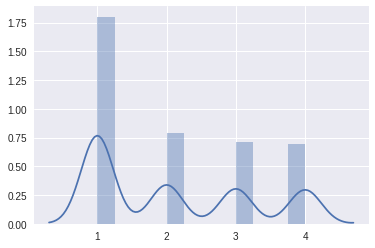

In [57]:
sns.distplot(batch_ratings)
batch_gen.shuffle()
batch_gen.index

In [11]:
padded_batch_xs, batch_ys, batch_lengths, batch_weights, max_length, batch_ratings = batch_gen.next_batch()
for i in xrange(len(padded_batch_xs)):
    0#print encoderDecoder.prettyDecode(padded_batch_xs[i]), batch_ratings[i]